In [440]:
import os
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import FunctionTransformer

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Build a Pipeline

## Central methods to call on the data

In [441]:
def load_titanic_data():
    return pd.read_csv(os.path.join('data', 'train.csv'))

In [442]:
def split_data(df):
    stratify_by = df["Pclass"]
    titanic_train, titanic_test = train_test_split(df, test_size=0.2, stratify=stratify_by, random_state=42)
    titanic_train_features = titanic_train.drop('Survived', axis=1)
    titanic_train_label = titanic_train['Survived']
    titanic_test_features = titanic_test.drop('Survived', axis=1)
    titanic_test_label = titanic_test['Survived']
    return titanic_train_features, titanic_train_label, titanic_test_features, titanic_test_label

In [443]:
titanic = load_titanic_data()
# we call the train set just "titanic"
X_train, y_train, X_test, y_test = split_data(titanic)

In [444]:
X_train.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
820,821,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
439,440,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
821,822,3,"Lulic, Mr. Nikola",male,27.0,0,0,315098,8.6625,NaN,S
403,404,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,STON/O2. 3101279,15.8500,NaN,S
343,344,2,"Sedgwick, Mr. Charles Frederick Waddington",male,25.0,0,0,244361,13.0000,NaN,S
514,515,3,"Coleff, Mr. Satio",male,24.0,0,0,349209,7.4958,NaN,S
40,41,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S
101,102,3,"Petroff, Mr. Pastcho (""Pentcho"")",male,NaN,0,0,349215,7.8958,NaN,S
93,94,3,"Dean, Mr. Bertram Frank",male,26.0,1,2,C.A. 2315,20.5750,NaN,S
81,82,3,"Sheerlinck, Mr. Jan Baptist",male,29.0,0,0,345779,9.5000,NaN,S


## Analyze the data

In [445]:
#TODO

## Preprocess the data

In [446]:
def drop_columns(df):
    columns_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
    return df.drop(columns_to_drop, axis=1)

In [447]:
def sex_pipeline():
    # we are going to use an OrdinalEncoder to make numerical data of the sex
    return Pipeline([
        ("encode", OrdinalEncoder())
    ])

In [448]:
def age_pipeline():
    # since there are lots of null values we are going to impute them
    return Pipeline([
        ("impute", SimpleImputer(strategy="median"))
    ])

In [449]:
def transform_sipsp_parch(df):
    # from SibSp and Parch, we create a new column "Alone"
    # Create a mask for the conditions
    mask = (df["SibSp"] == 0) & (df["Parch"] == 0)

    # Create a new column, initialized with 1
    df.loc[:, "Alone"] = 1

    df.loc[~mask, "Alone"] = 0 # set 0 where the condition is not met
    df = df.drop(["SibSp", "Parch"], axis=1)
    return df

In [450]:
def embarked_pipeline():
    # we impute the null values with the most frequent and afterward encode it
    return  Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OrdinalEncoder())
    ])


In [451]:
def fare_pipeline():
    # we impute the null values with the median
    return Pipeline([
        ("impute", SimpleImputer(strategy="median"))
    ])

In [452]:
def full_preprocessing(X, preprocessing_pipeline):
    # drop the columns
    X = drop_columns(X)

    transformer = FunctionTransformer(transform_sipsp_parch)
    X = transformer.transform(X)

    return pd.DataFrame(preprocessing_pipeline.fit_transform(X), columns=preprocessing_pipeline.get_feature_names_out(), index=X.index)


transformers = [
    ('Sex', sex_pipeline(), ['Sex']),
    ('Age', age_pipeline(), ['Age']),
    ('Embarked', embarked_pipeline(), ['Embarked']),
    ('Fare', fare_pipeline(), ['Fare'])
]

# Create the ColumnTransformer
ct = ColumnTransformer(transformers, remainder="passthrough")

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ("preprocessor", ct)
])

X_train = full_preprocessing(X_train, preprocessing_pipeline)

In [453]:
X_train.head(10)

,Sex__Sex,Age__Age,Embarked__Embarked,Fare__Fare,remainder__Pclass,remainder__Alone
820,0.0,52.0,2.0,93.5000,1.0,0.0
439,1.0,31.0,2.0,10.5000,2.0,1.0
821,1.0,27.0,2.0,8.6625,3.0,1.0
403,1.0,28.0,2.0,15.8500,3.0,0.0
343,1.0,25.0,2.0,13.0000,2.0,1.0
514,1.0,24.0,2.0,7.4958,3.0,1.0
40,0.0,40.0,2.0,9.4750,3.0,0.0
101,1.0,28.0,2.0,7.8958,3.0,1.0
93,1.0,26.0,2.0,20.5750,3.0,0.0
81,1.0,29.0,2.0,9.5000,3.0,1.0


In [454]:
# now we have no null values any more
X_train.isna().sum()

Sex__Sex              0
Age__Age              0
Embarked__Embarked    0
Fare__Fare            0
remainder__Pclass     0
remainder__Alone      0
dtype: int64

# Train the data

## KNeighborsRegressor

In [455]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
print("The score of our model is ", knn_model.score(X_train, y_train))

The score of our model is  0.3965423280423278


In [456]:
cv_results = cross_validate(knn_model, X_train, y_train, cv=5, verbose=5)
print("The score of our model is ", knn_model.score(X_train, y_train))

[CV] END ......................................., score=0.056 total time=   0.0s
[CV] END ......................................., score=0.228 total time=   0.0s
[CV] END ......................................., score=0.182 total time=   0.0s
[CV] END ......................................., score=0.048 total time=   0.0s
[CV] END ......................................, score=-0.015 total time=   0.0s
The score of our model is  0.3965423280423278


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [457]:
grid = GridSearchCV(estimator=KNeighborsRegressor(),
                   param_grid={"n_neighbors": range(1, 20)},
                   return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 20)}, return_train_score=True)

In [458]:
print(f"Best param: {grid.best_params_}, best score: {grid.best_score_}")

Best param: {'n_neighbors': 11}, best score: 0.15360284078562964


In [459]:
best_model = grid.best_estimator_
print("The score of our model is ", best_model.score(X_train, y_train))

The score of our model is  0.29958568367659266


## DecisionTreeRegressor

In [460]:
dtr_model = DecisionTreeRegressor()
dtr_model.fit(X_train, y_train)
print("The score of our model is ", dtr_model.score(X_train, y_train))

The score of our model is  0.9587472442680776


This could be a sign of overfitting!

In [461]:
search_space = {
    'max_depth': [None, 1,2,3],
    'splitter': ["best", "random"],
    'min_samples_split': [2,3,4]
}   # these are possibilities how the DecisionTreeRegressor can be configured
grid = GridSearchCV(estimator=DecisionTreeRegressor(),
                    param_grid=search_space,
                    return_train_score=True,
                    )
grid.fit(X_train, y_train)
results = grid.cv_results_
results = pd.DataFrame(results)
print("Best estimator: ", grid.best_estimator_)
print("Score of best estimator: ", grid.best_estimator_.score(X_train, y_train))

Best estimator:  DecisionTreeRegressor(max_depth=3)
Score of best estimator:  0.4766314666931034


In [462]:
best_model = grid.best_estimator_
print("The score of our model is ", best_model.score(X_train, y_train))

The score of our model is  0.4766314666931034


## LogisticRegression

In [463]:
lr_model = LogisticRegression(max_iter=1000, penalty=None)
lr_model.fit(X_train, y_train)
print("The score of our model is ", lr_model.score(X_train, y_train))

The score of our model is  0.797752808988764


# Test the data

In [464]:
# preprocess the test data
X_test = full_preprocessing(X_test, preprocessing_pipeline)
X_test.head(10)

,Sex__Sex,Age__Age,Embarked__Embarked,Fare__Fare,remainder__Pclass,remainder__Alone
132,0.0,47.00,2.0,14.5000,3.0,0.0
3,0.0,35.00,2.0,53.1000,1.0,0.0
270,1.0,28.75,2.0,31.0000,1.0,1.0
421,1.0,21.00,1.0,7.7333,3.0,1.0
154,1.0,28.75,2.0,7.3125,3.0,1.0
292,1.0,36.00,0.0,12.8750,2.0,1.0
304,1.0,28.75,2.0,8.0500,3.0,1.0
202,1.0,34.00,2.0,6.4958,3.0,1.0
810,1.0,26.00,2.0,7.8875,3.0,1.0
108,1.0,38.00,2.0,7.8958,3.0,1.0


In [465]:
final_predictions = lr_model.predict(X_test)

## Final Scores

In [466]:
cm = confusion_matrix(y_test, final_predictions)
cm

array([[96, 21],
       [18, 44]], dtype=int64)

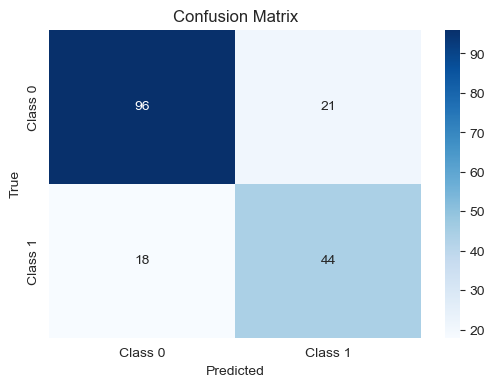

In [467]:
# Define class labels
labels = ['Class 0', 'Class 1']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Set labels, title, and ticks
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)

# Display the plot
plt.show()

In [468]:
print("The precision score is ", precision_score(y_test, final_predictions))
print("The recall score is ", recall_score(y_test, final_predictions))
print("The f1 score is ", f1_score(y_test, final_predictions))

The precision score is  0.676923076923077
The recall score is  0.7096774193548387
The f1 score is  0.6929133858267716


# Create result for Kaggle

In [469]:
def load_titanic_test_data():
    return pd.read_csv(os.path.join('data', 'test.csv'))

X_final = load_titanic_test_data()
X_final.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [470]:
# we need to save the PassengerId
x_final_passenger_id = X_final["PassengerId"]

In [471]:
# preprocess the data
X_final = full_preprocessing(X_final, preprocessing_pipeline)
X_final.head(10)

,Sex__Sex,Age__Age,Embarked__Embarked,Fare__Fare,remainder__Pclass,remainder__Alone
0,1.0,34.5,1.0,7.8292,3.0,1.0
1,0.0,47.0,2.0,7.0000,3.0,0.0
2,1.0,62.0,1.0,9.6875,2.0,1.0
3,1.0,27.0,2.0,8.6625,3.0,1.0
4,0.0,22.0,2.0,12.2875,3.0,0.0
5,1.0,14.0,2.0,9.2250,3.0,1.0
6,0.0,30.0,1.0,7.6292,3.0,1.0
7,1.0,26.0,2.0,29.0000,2.0,0.0
8,0.0,18.0,0.0,7.2292,3.0,1.0
9,1.0,21.0,2.0,24.1500,3.0,0.0


In [472]:
y_final = lr_model.predict(X_final)

In [473]:
print(type(x_final_passenger_id))
print(type(y_final))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [474]:
df_final = pd.DataFrame(x_final_passenger_id)
df_final["Survived"] = y_final
df_final.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [475]:
filepath = Path('result.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_final.to_csv(filepath, index=False)